In [1]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from os import path
import sys
sys.path.append(path.join(".."))

import saly
import saly.backend as S
import pandas as pd
import numpy as np

%load_ext autoreload
%autoreload 2

EPOCHS = 6
SPECIES = 'Mouse'
DATA_PATH = '/home/mlongar/Data/SingleCellGeneExpression/'
DATASET_HRVATIN_PATH = DATA_PATH + 'hrvatin_2018.h5ad' 
DATASET_CHEN_PATH = DATA_PATH + 'chen_2017.h5ad'
DATASET_BIG_PATH = DATA_PATH + '10x_mouse_1.3mln.h5ad'
MARKER_PATH = DATA_PATH + 'panglao_gene_markers.tab.gz'

Using TensorFlow backend.


In [2]:
hrvatin_data = saly.load_h5ad(DATASET_HRVATIN_PATH)
print("HRVATIN DATA\n", hrvatin_data.shape)

HRVATIN DATA
 (48266, 25186)


In [3]:
chen_data = saly.load_h5ad(DATASET_CHEN_PATH)
print("CHEN DATA\n", chen_data.shape)

CHEN DATA
 (14437, 23284)


In [4]:
big_data = saly.load_h5ad(DATASET_BIG_PATH)
print("BIG DATA\n", big_data.shape)

BIG DATA
 (1306127, 27932)


In [5]:
chen_data = saly.drop_rows(chen_data, ['tanycyte', 'unknown', 'ependymal cell', 'epithelial cell'])

Dropped 4750 cell(s). New shape: (9687, 23284)


In [6]:
markers_db = saly.load_markers(MARKER_PATH, SPECIES)
markers = saly.get_mutual_markers([hrvatin_data, chen_data, big_data], markers_db)
print('Mutual markers:', len(markers))

Mutual markers: 7382


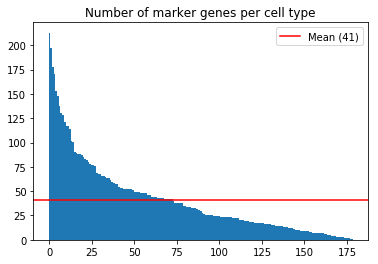

In [7]:
saly.plot_marker_genes(markers)

In [8]:
marker_aliases = {'Neuron' : 'Neurons',
                'Oligodendrocyte' : 'Oligodendrocytes',
                'Muscle cell' : 'Smooth muscle cells',
                'Endothelial cell' : 'Endothelial cells',
                'Astrocyte' : 'Astrocytes',
                'Macrophage' : 'Macrophages',
                'OPC' : 'Oligodendrocyte progenitor cells',
                'Pericyte' : 'Pericytes'}

saly.check_labels([hrvatin_data, chen_data], markers, marker_aliases)

In [9]:
hrvatin_data = saly.drop_unused_genes(hrvatin_data, markers)
chen_data = saly.drop_unused_genes(chen_data, markers)
big_data = saly.drop_unused_genes(big_data, markers)

saly.check_shape([hrvatin_data, chen_data, big_data])

Dropped 21107 gene(s). New shape: (48266, 4079)
Dropped 19205 gene(s). New shape: (9687, 4079)
Dropped 23853 gene(s). New shape: (1306127, 4079)


In [10]:
big_data = saly.mark_as_unlabelled(big_data.copy())

In [11]:
train_data, _, _ = saly.preprocess_data(big_data, splits=10,
                                       train=1, test=0, validation=0)

In [12]:
chen_data = S.normalize_data(chen_data.copy())
hrvatin_data = S.normalize_data(hrvatin_data.copy())

In [39]:
model, marker_model, encoder_model = saly.build_model(train_data, markers, supervised=False);

In [40]:
history = saly.train_model(model, train_data, markers, marker_aliases,
                           EPOCHS, validation_data=chen_data, verbose=1)

Train on 1306127 samples, validate on 9687 samples
Epoch 1/6
1306127/1306127 [==============================] - 102s 78us/step - loss: 2124.3082 - cell_activations_loss: 0.0000e+00 - output_loss: 2.1243 - cell_activations_marker_prediction_metric: 1.5312e-06 - val_loss: 2951.0978 - val_cell_activations_loss: 0.0000e+00 - val_output_loss: 2.9511 - val_cell_activations_marker_prediction_metric: 0.7720
Epoch 2/6
1306127/1306127 [==============================] - 97s 74us/step - loss: 2032.5402 - cell_activations_loss: 0.0000e+00 - output_loss: 2.0325 - cell_activations_marker_prediction_metric: 0.0000e+00 - val_loss: 2915.7166 - val_cell_activations_loss: 0.0000e+00 - val_output_loss: 2.9157 - val_cell_activations_marker_prediction_metric: 0.7836
Epoch 3/6
1306127/1306127 [==============================] - 96s 73us/step - loss: 2010.6570 - cell_activations_loss: 0.0000e+00 - output_loss: 2.0107 - cell_activations_marker_prediction_metric: 0.0000e+00 - val_loss: 2941.0081 - val_cell_activa

In [15]:
chen_baseline = saly.get_baseline(chen_data, markers)
validation_baseline = saly.get_results(chen_data.obs['labels'], chen_baseline.X.toarray(), markers, marker_aliases)

Correct predictions: 6623 out of 9687 (68.37%)
	Neuron: 42.07% (974/2315) | Markers: 197
	Oligodendrocyte: 77.15% (2732/3541) | Markers: 85
	OPC: 95.48% (1711/1792) | Markers: 28
	Astrocyte: 57.4% (659/1148) | Markers: 61
	Microglia: 70.99% (514/724) | Markers: 80
	Macrophage: 19.76% (33/167) | Markers: 130


In [16]:
hrvatin_baseline = saly.get_baseline(hrvatin_data, markers)
saly.get_results(hrvatin_data.obs['labels'], hrvatin_baseline.X.toarray(), markers, marker_aliases);

Correct predictions: 25021 out of 48266 (51.84%)
	Neuron: 10.37% (1579/15223) | Markers: 197
	Oligodendrocyte: 63.82% (5508/8630) | Markers: 85
	Muscle cell: 0.0% (0/621) | Markers: 77
	Astrocyte: 75.72% (5330/7039) | Markers: 61
	Endothelial cell: 50.61% (1746/3450) | Markers: 178
	Macrophage: 1.68% (9/537) | Markers: 130
	Microglia: 89.09% (9050/10158) | Markers: 80
	OPC: 97.81% (1786/1826) | Markers: 28
	Pericyte: 1.66% (13/782) | Markers: 64


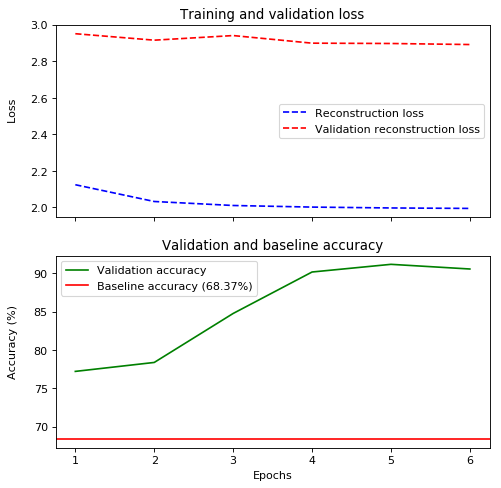

In [41]:
saly.plot_model_history(history, validation_baseline, supervised=False, labelled_training=False)

In [42]:
chen_cell_activations = marker_model.predict(chen_data.X)
saly.get_results(chen_data.obs['labels'], chen_cell_activations, markers, marker_aliases);

Correct predictions: 8772 out of 9687 (90.55%)
	Neuron: 99.57% (2305/2315) | Markers: 197
	Oligodendrocyte: 97.85% (3465/3541) | Markers: 85
	OPC: 96.65% (1732/1792) | Markers: 28
	Astrocyte: 88.85% (1020/1148) | Markers: 61
	Microglia: 25.41% (184/724) | Markers: 80
	Macrophage: 39.52% (66/167) | Markers: 130


In [43]:
hrvatin_cell_activations = marker_model.predict(hrvatin_data.X)
saly.get_results(hrvatin_data.obs['labels'], hrvatin_cell_activations, markers, marker_aliases);

Correct predictions: 36484 out of 48266 (75.59%)
	Neuron: 100.0% (15223/15223) | Markers: 197
	Oligodendrocyte: 92.27% (7963/8630) | Markers: 85
	Muscle cell: 0.0% (0/621) | Markers: 77
	Astrocyte: 99.35% (6993/7039) | Markers: 61
	Endothelial cell: 100.0% (3450/3450) | Markers: 178
	Macrophage: 53.82% (289/537) | Markers: 130
	Microglia: 0.01% (1/10158) | Markers: 80
	OPC: 99.67% (1820/1826) | Markers: 28
	Pericyte: 95.27% (745/782) | Markers: 64


# Analysis

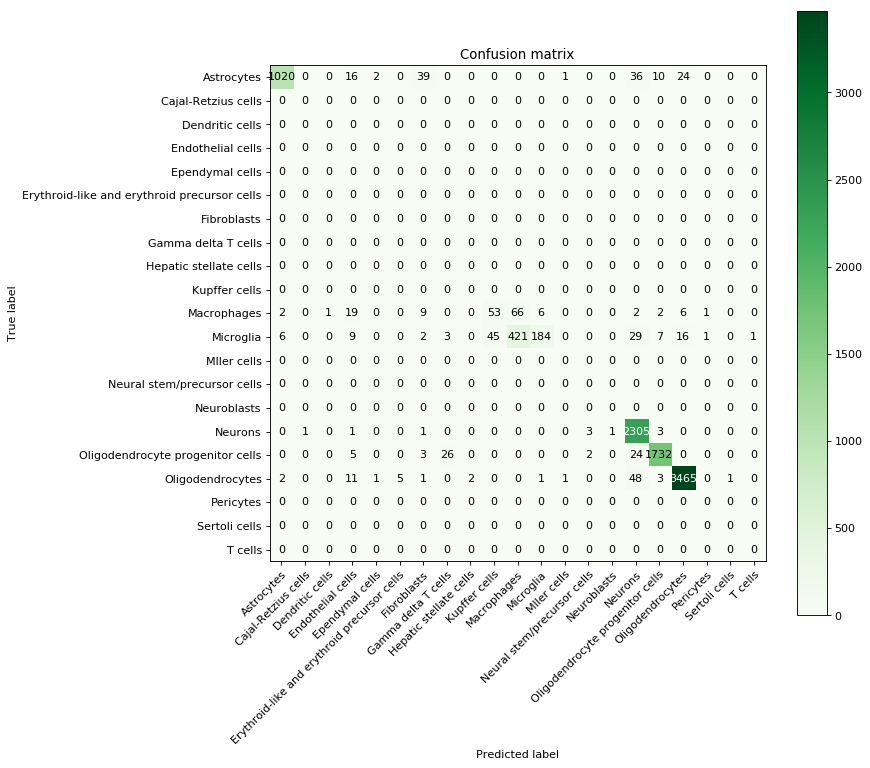

In [117]:
saly.draw_confusion_matrix(chen_data.obs['labels'], chen_cell_activations, markers, marker_aliases)

/home/mlongar/miniconda/envs/MG/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


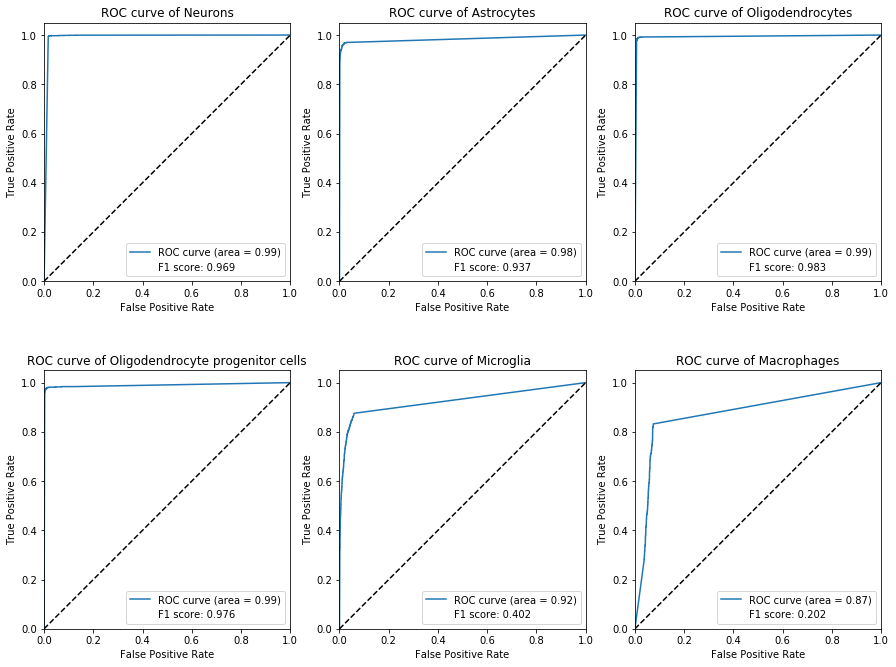

Average ROC AUC: 0.959


In [214]:
saly.draw_roc(chen_data.obs['labels'], chen_cell_activations, markers, marker_aliases)